# Import

In [9]:
%reload_ext autoreload
%autoreload 2

In [10]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder


# import seaborn as sns
from keras.models import Sequential
# from tensorflow.keras.layers import Dense,Dropout, MaxPooling1D
from tensorflow.keras.utils import to_categorical
# from tensorflow.keras.callbacks import CSVLogger, EarlyStopping
import copy

import tensorflow as tf 


import torch 
import torch.nn as nn
import torch.nn.functional as F
# import transforms

import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torch.optim.lr_scheduler import StepLR
import torchvision.transforms as transforms

import opacus
from opacus import PrivacyEngine
from tqdm  import tqdm
import torch.utils.data as torch_data

import tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.membership_inference_attack as mia
from tensorflow_privacy.privacy.membership_inference_attack.data_structures import AttackInputData
from tensorflow_privacy.privacy.membership_inference_attack.data_structures import SlicingSpec
from tensorflow_privacy.privacy.membership_inference_attack.data_structures import AttackType
import tensorflow_privacy.privacy.membership_inference_attack.plotting as plotting


from data_utils import get_depth_data, HARDataset,get_dataset 
from model_utils import * 
from utils import * 

# MIA


In [13]:

def run_mia_attack(model, train_dl, test_dl) : 
  """
  given a model, and one-hot encoded train and test labels, the function applies the Membership Inference Attack (MIA) and returns results 
  """
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  model.to(device) 
  model.eval()
  cce = nn.CrossEntropyLoss(reduction = 'none')
  train_losses, train_logits, all_train_labels = [], [], []
  for batch in train_dl : 
    train_data, train_labels = batch 
    train_data.to(device)
    train_labels.to(device)

    logits, probs = model(train_data)
    train_loss = cce(logits, train_labels).detach().cpu().numpy()
    logits = logits.detach().cpu().numpy()
    train_labels = train_labels.detach().cpu().numpy().astype(int)
    train_losses.append(train_loss)
    train_logits.append(logits)
    all_train_labels.append(np.argmax(train_labels, axis = 1))
  
  train_logits = np.concatenate(train_logits)
  train_losses = np.concatenate(train_losses)
  
  test_losses, test_logits, all_test_labels = [], [], []
  for batch in test_dl :
    test_data, test_labels = batch 
    test_data.to(device)
    test_labels.to(device)

    logits, probs = model(test_data)
    test_loss = cce(logits, test_labels).detach().cpu().numpy()
    logits = logits.detach().cpu().numpy()
    test_labels = test_labels.detach().cpu().numpy().astype(int)
    test_losses.append(test_loss)
    test_logits.append(logits)
    all_test_labels.append(np.argmax(test_labels, axis = 1))
    
  test_losses, test_logits = np.concatenate(test_losses), np.concatenate(test_logits)
  all_train_labels, all_test_labels = np.concatenate(all_train_labels), np.concatenate(all_test_labels)
  print(all_train_labels.shape, all_test_labels.shape)
  # define what variables our attacker should have access to
  attack_input = AttackInputData(
  logits_train = train_logits,
  logits_test = test_logits, 
  loss_train = train_losses, 
  loss_test = test_losses, 
  labels_train = all_train_labels, 
  labels_test = all_test_labels
  )
  # define the type of attacker model that we want to use
  attack_types = [
      AttackType.THRESHOLD_ATTACK,
      AttackType.LOGISTIC_REGRESSION, 
      AttackType.MULTI_LAYERED_PERCEPTRON
  ]
  # how should the data be sliced
  slicing_spec = SlicingSpec(
    entire_dataset = True,
    by_class = True,
    by_percentiles = False,
    by_classification_correctness = True)
  
  attacks_result = mia.run_attacks(attack_input=attack_input,
                                 slicing_spec=slicing_spec,
                                 attack_types=attack_types)
  return attacks_result 


# model = HAR_CV_Net(input_shape = [20, 20], f1 = 10, f2 = 20, f3 = 25, n_classes = 5)
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# model.to(device)
# attack_res = run_mia_attack(model, big_train_dl, big_test_dl)

# function to that takes a dataset and a list of class labels and returns a dataset with only the specified labels
def filter_dataset(dataset, classes) :
  """
  given a dataset and a list of class labels, the function returns a dataset with only the specified labels
  """
  data, labels_cat = dataset
  labels = np.argmax(labels_cat, axis = 1)
  mask = np.isin(labels, classes)
  data, labels_cat = data[mask], labels_cat[mask]
  return data, labels_cat

  

# Federated Learning (depth data)

In [91]:
dataset = 'hars' 
n_pub_sets = 1
central_train_set, central_test_set, public_set, local_sets, test_sets = get_dataset(dataset, n_pub_sets = n_pub_sets) 
print("num classes:", len(np.unique(np.argmax(central_train_set[1], axis = 1))))

local_train_set = filter_dataset(central_train_set, [0, 1, 2])
local_train_dataloader = DataLoader(torch_data.TensorDataset(torch.tensor(local_train_set[0]), torch.tensor(local_train_set[1])), batch_size = 32, shuffle = True)

fl_train_set = filter_dataset(central_train_set, [0, 1, 2, 3, 4, 5])
fl_train_dataloader = DataLoader(torch_data.TensorDataset(torch.tensor(fl_train_set[0]), torch.tensor(fl_train_set[1])), batch_size = 32, shuffle = True)

central_train_dl = DataLoader(torch_data.TensorDataset(torch.tensor(central_train_set[0]), torch.tensor(central_train_set[1])), batch_size = 32, shuffle = True)

test_set = (test_sets[0][0], test_sets[0][1])
test_dl = DataLoader(torch_data.TensorDataset(torch.tensor(test_sets[0][0]), torch.tensor(test_sets[0][1])), batch_size = 32, shuffle = True)




num classes: 6


/Users/gadmohamed/miniforge3/envs/fl/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/gadmohamed/miniforge3/envs/fl/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [99]:
local_model = get_heterogeneous_model(0, local_train_set[0].shape, n_classes = local_train_set[1].shape[-1])
opt = torch.optim.SGD(local_model.parameters(), lr = 0.001)
cce = nn.CrossEntropyLoss()

for i in range(70):
    train(local_model, local_train_dataloader, cce, opt, privacy_engine = None, DELTA = None, device = None, verbose = True)

test(local_model, test_dl, cce, privacy_engine = None, DELTA = None, device = None, verbose = True)



Train Accuracy: 0.320574Train Loss: 1.784047
Train Accuracy: 0.333580Train Loss: 1.773227
Train Accuracy: 0.333087Train Loss: 1.762253
Train Accuracy: 0.333457Train Loss: 1.751281
Train Accuracy: 0.333395Train Loss: 1.740467
Train Accuracy: 0.333580Train Loss: 1.729491
Train Accuracy: 0.333210Train Loss: 1.718853
Train Accuracy: 0.333580Train Loss: 1.708245
Train Accuracy: 0.333148Train Loss: 1.698851
Train Accuracy: 0.333395Train Loss: 1.689472
Train Accuracy: 0.334936Train Loss: 1.681030
Train Accuracy: 0.336662Train Loss: 1.673387
Train Accuracy: 0.339127Train Loss: 1.666737
Train Accuracy: 0.362611Train Loss: 1.659947
Train Accuracy: 0.421043Train Loss: 1.653763
Train Accuracy: 0.496795Train Loss: 1.648311
Train Accuracy: 0.575259Train Loss: 1.642492
Train Accuracy: 0.607988Train Loss: 1.637939
Train Accuracy: 0.614337Train Loss: 1.632683
Train Accuracy: 0.586415Train Loss: 1.628284
Train Accuracy: 0.553439Train Loss: 1.623387
Train Accuracy: 0.522374Train Loss: 1.618458
Train Accu

(0.36917562724014336, 1.6593484506812146)

In [100]:
fl_model = get_heterogeneous_model(0, fl_train_set[0].shape, n_classes = fl_train_set[1].shape[-1])
opt = torch.optim.SGD(fl_model.parameters(), lr = 0.001)
cce = nn.CrossEntropyLoss()

for i in range(70):
    train(fl_model, central_train_dl, cce, opt, privacy_engine = None, DELTA = None, device = None, verbose = True)

test(fl_model, test_dl, cce, privacy_engine = None, DELTA = None, device = None, verbose = True)



Train Accuracy: 0.192585Train Loss: 1.789998
Train Accuracy: 0.235484Train Loss: 1.785633
Train Accuracy: 0.283931Train Loss: 1.781412
Train Accuracy: 0.339405Train Loss: 1.777036
Train Accuracy: 0.355584Train Loss: 1.772653
Train Accuracy: 0.351886Train Loss: 1.767946
Train Accuracy: 0.350777Train Loss: 1.762953
Train Accuracy: 0.359098Train Loss: 1.757625
Train Accuracy: 0.372134Train Loss: 1.751843
Train Accuracy: 0.388683Train Loss: 1.746061
Train Accuracy: 0.394508Train Loss: 1.739982
Train Accuracy: 0.408561Train Loss: 1.733442
Train Accuracy: 0.410411Train Loss: 1.726846
Train Accuracy: 0.418454Train Loss: 1.720199
Train Accuracy: 0.424741Train Loss: 1.713550
Train Accuracy: 0.414756Train Loss: 1.707159
Train Accuracy: 0.414571Train Loss: 1.700685
Train Accuracy: 0.401812Train Loss: 1.694423
Train Accuracy: 0.392844Train Loss: 1.688074
Train Accuracy: 0.386927Train Loss: 1.682206
Train Accuracy: 0.375740Train Loss: 1.676443
Train Accuracy: 0.365107Train Loss: 1.671071
Train Accu

(0.6988127240143369, 1.4480068696442472)

In [101]:
# A function that takes predictions and prints out per-class accuracy
def get_per_class_accuracy(predictions, labels):
    classes = np.unique(labels) 
    class_accs = [] 
    for i, cls in enumerate(classes) : 
        tot = np.sum(labels == cls)
        correct = np.sum((predictions == cls) & (labels == cls))
        acc = correct / tot
        class_accs.append(acc)
        print("accuracy {} total {}".format(acc, tot))
    print() 
    return class_accs

def get_preds(model, test_dl):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    preds = []
    for x, y in test_dl : 
        x, y = x.to(device).float(), y.to(device).float()
        logits, probs = model(x) 
        preds.append(probs.cpu().detach().numpy())
    preds = np.concatenate(preds)
    return preds 

ys_cat = test_set[1]
ys = np.argmax(test_set[1], axis = 1)

fl_preds_cat = get_preds(fl_model, test_dl)
fl_preds = np.argmax(fl_preds_cat, axis = 1)
fl_accs = get_per_class_accuracy(fl_preds, ys) 

local_preds_cat = get_preds(local_model, test_dl)
local_preds = np.argmax(local_preds_cat, axis = 1)
local_accs = get_per_class_accuracy(local_preds, ys)

fl_accs, local_accs

accuracy 0.20670391061452514 total 537
accuracy 0.0 total 491
accuracy 0.34962406015037595 total 532
accuracy 0.08669354838709678 total 496
accuracy 0.1761904761904762 total 420
accuracy 0.18471337579617833 total 471

accuracy 0.186219739292365 total 537
accuracy 0.018329938900203666 total 491
accuracy 0.7988721804511278 total 532
accuracy 0.0 total 496
accuracy 0.0 total 420
accuracy 0.0 total 471



([0.20670391061452514,
  0.0,
  0.34962406015037595,
  0.08669354838709678,
  0.1761904761904762,
  0.18471337579617833],
 [0.186219739292365, 0.018329938900203666, 0.7988721804511278, 0.0, 0.0, 0.0])

# Plotting :))


# Confusion Matrix

In [102]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def plot_confusion_matrices(predictions, ground_truth, n_rows, n_cols, display_labels, titles):
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, 8), constrained_layout=True)
    for i, preds in enumerate(predictions):
        cm = confusion_matrix(ground_truth, preds)
        cm_display = ConfusionMatrixDisplay(cm, display_labels=display_labels).plot(ax = axs[i])
        axs[i].set_title(titles[i], fontsize = 30)
        axs[i].tick_params(axis='both', which='major', labelsize=25)
        axs[i].set_xlabel('Predicted Label', fontsize = 30)
        axs[i].set_ylabel('True Label', fontsize = 30)
    plt.show()




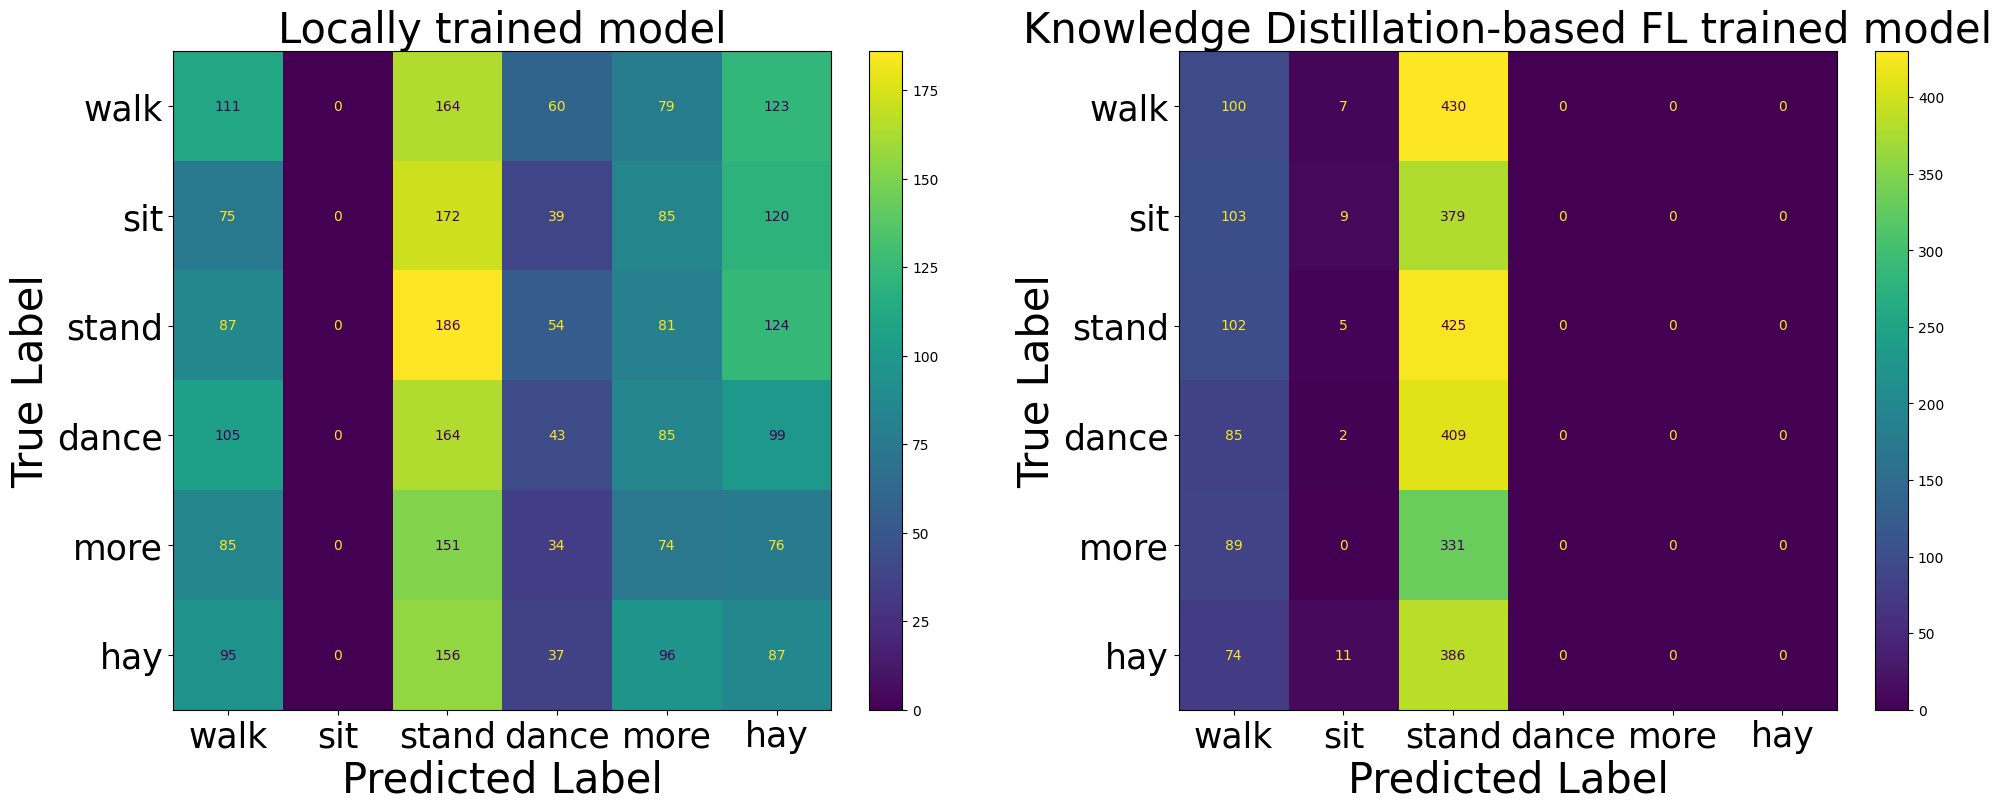

In [104]:
titles = [
    'Locally trained model', 
    'Knowledge Distillation-based FL trained model'
]
plot_confusion_matrices([fl_preds, local_preds], ys, 1, 2, ['walk', 'sit', 'stand', 'dance', 'more', 'hay'], titles)


## Roc Curve

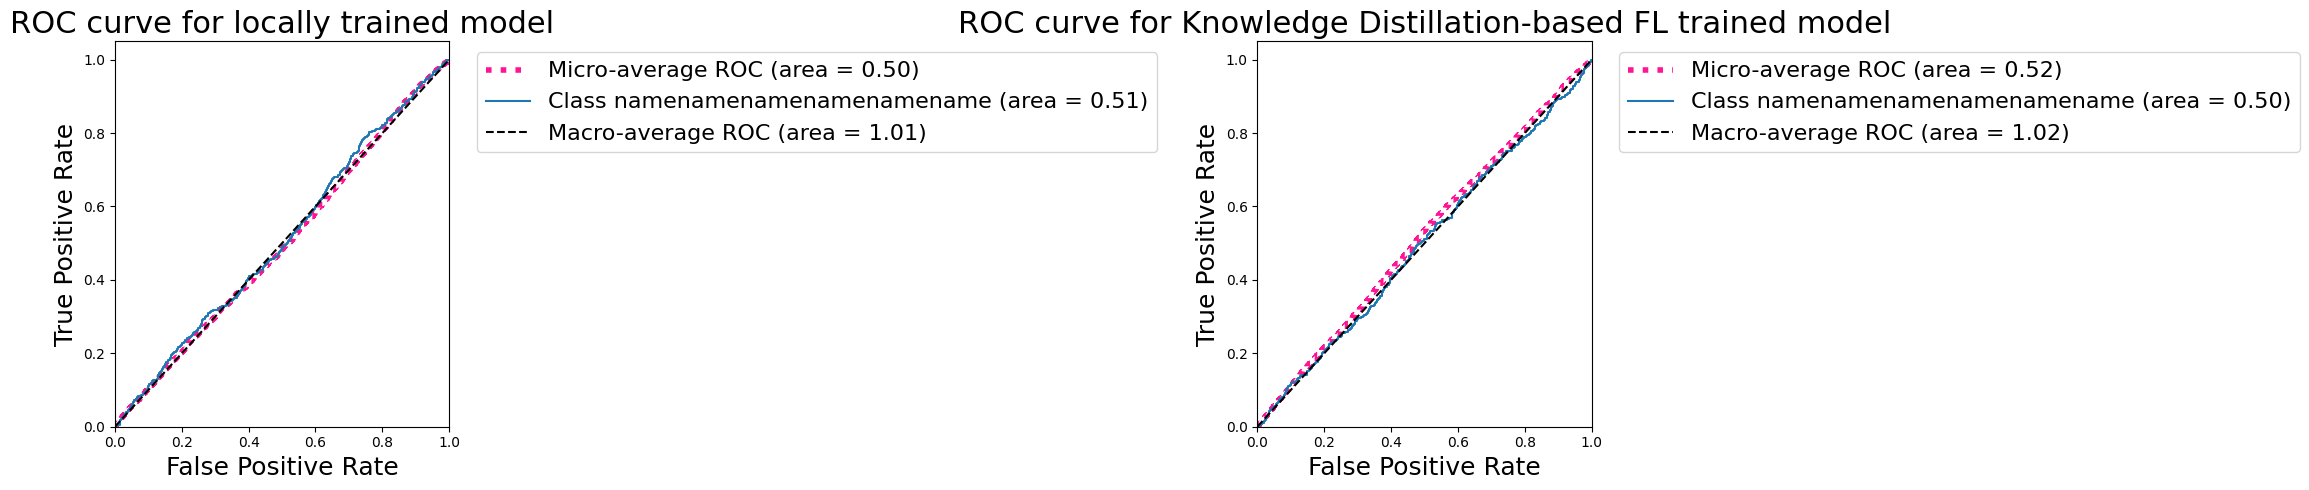

FileNotFoundError: [Errno 2] No such file or directory: '../plots/compare_roc_curve.pdf'

In [105]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from scipy import interp
from itertools import cycle

def compare_roc_curve(model1_preds, model1_ground_truth, model2_preds, model2_ground_truth, original_labels, titles):
    n_classes = len(original_labels)
    # Compute ROC curve and ROC area for each class of model 1
    model1_fpr = dict()
    model1_tpr = dict()
    model1_roc_auc = dict()
    for i in range(n_classes):
        model1_fpr[i], model1_tpr[i], _ = roc_curve(model1_ground_truth[:, i], model1_preds[:, i])
        model1_roc_auc[i] = auc(model1_fpr[i], model1_tpr[i])

    # Compute micro-average ROC curve and ROC area of model 1
    model1_fpr["micro"], model1_tpr["micro"], _ = roc_curve(model1_ground_truth.ravel(), model1_preds.ravel())
    model1_roc_auc["micro"] = auc(model1_fpr["micro"], model1_tpr["micro"])

    # Compute ROC curve and ROC area for each class of model 2
    model2_fpr = dict()
    model2_tpr = dict()
    model2_roc_auc = dict()
    for i in range(n_classes):
        model2_fpr[i], model2_tpr[i], _ = roc_curve(model2_ground_truth[:, i], model2_preds[:, i])
        model2_roc_auc[i] = auc(model2_fpr[i], model2_tpr[i])

    # Compute micro-average ROC curve and ROC area of model 2
    model2_fpr["micro"], model2_tpr["micro"], _ = roc_curve(model2_ground_truth.ravel(), model2_preds.ravel())
    model2_roc_auc["micro"] = auc(model2_fpr["micro"], model2_tpr["micro"])



    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(23,5))

    # Plot micro-average ROC curve
    ax1.plot(model1_fpr["micro"], model1_tpr["micro"],
                label='Micro-average ROC (area = {0:0.2f})'
                    ''.format(model1_roc_auc["micro"]),
                color='deeppink', linestyle=':', linewidth=4)

    # Plot ROC curve for each class
    for i in range(n_classes):
        ax1.plot(model1_fpr[i], model1_tpr[i], label='Class {0} (area = {1:0.2f})'
                                                ''.format(original_labels[i], model1_roc_auc[i]))

    # Plot macro-average ROC curve
    macro_roc_auc = sum(model1_roc_auc.values()) / n_classes
    ax1.plot([0, 1], [0, 1], 'k--', label='Macro-average ROC (area = {0:0.2f})'.format(macro_roc_auc))

    ax1.set_xlim([0.0, 1.0])
    ax1.set_ylim([0.0, 1.05])
    ax1.set_xlabel('False Positive Rate', fontdict={'size': 18})
    ax1.set_ylabel('True Positive Rate', fontdict={'size': 18})
    ax1.set_title(titles[0], fontdict={'size': 22})
    ax1.legend(loc="lower right", prop={'size': 16})


    # Plot micro-average ROC curve
    ax2.plot(model2_fpr["micro"], model2_tpr["micro"],
                label='Micro-average ROC (area = {0:0.2f})'
                    ''.format(model2_roc_auc["micro"]),
                color='deeppink', linestyle=':', linewidth=4)

    # Plot ROC curve for each class
    for i in range(n_classes):
        ax2.plot(model2_fpr[i], model2_tpr[i], label='Class {0} (area = {1:0.2f})'
                                                ''.format(original_labels[i], model2_roc_auc[i]))

    # Plot macro-average ROC curve
    macro_roc_auc = sum(model2_roc_auc.values()) / n_classes
    ax2.plot([0, 1], [0, 1], 'k--', label='Macro-average ROC (area = {0:0.2f})'.format(macro_roc_auc))

    ax2.set_xlim([0.0, 1.0])
    ax2.set_ylim([0.0, 1.05])
    ax2.set_xlabel('False Positive Rate', fontdict={'size': 18})
    ax2.set_ylabel('True Positive Rate', fontdict={'size': 18})
    ax2.set_title(titles[1], fontdict={'size': 22})
    ax2.legend(loc="lower right", prop={'size': 16})

    ax1.legend(loc="upper left", bbox_to_anchor=(1.05, 1), prop={'size': 16})
    ax2.legend(loc="upper left", bbox_to_anchor=(1.05, 1), prop={'size': 16})

    fig.tight_layout()
    plt.show()
    # save the file as pdf 
    fig.savefig('../plots/compare_roc_curve.pdf', bbox_inches='tight')




titles = [
    'ROC curve for locally trained model',
    'ROC curve for Knowledge Distillation-based FL trained model',
]
labels = ['name' * ys_cat.shape[1]]
compare_roc_curve(fl_preds_cat, ys_cat, local_preds_cat, ys_cat, labels, titles)